In [20]:
import numpy as np
import nibabel as nb
import glob
import matplotlib.pyplot as plt
import cv2
import h5py
import os
from tqdm import tqdm
## the directory with datatset
root_dir = "/home/jaye/Documents/MedicalDatasets/ACDC/training/*/*"
files = glob.glob(root_dir)
labels = []
images = []
# test_list = ['002','003','008','009','012','014','017','024','042','048']#
test_list = ['049','053','055','064','067','079','081','088','092','095']
for each in files:
    if "frame" in each and "gt" in each:
        labels.append(each)
    elif "frame" in each:
        images.append(each)
        
print(images[0])
patient = images[0].split("/")[-2]
print(patient)
image = nb.load(images[3]).get_fdata()
print(image.shape)

/home/jaye/Documents/MedicalDatasets/ACDC/training/patient095/patient095_frame01.nii.gz
patient095
(216, 256, 7)


In [24]:
os.makedirs('/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/train_npz',exist_ok=True)
os.makedirs('/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/test_npz',exist_ok=True)
os.makedirs('/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/test_vol_h5',exist_ok=True)
os.makedirs('/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/lists_ACDC/',exist_ok=True)
prev_patient = "patient001"
slice_num = 0
train_file = open('/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/lists_ACDC/train.txt','w')
test_file = open('/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/lists_ACDC/test.txt','w')
test_h5_file = open('/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/lists_ACDC/test_vol.txt','w')
for i in tqdm(range(len(images))):
    slice_num=0
    patient = images[i].split("/")[-2]
    image = nb.load(images[i]).get_fdata()
    label = nb.load(labels[i]).get_fdata()
    image = image/255
    size = image.shape
    if size[0]>size[1]:
        pad_left = (size[0]-size[1])//2+(size[0]-size[1])%2
        pad_right = (size[0]-size[1])//2
        image = np.pad(image,((0,0),(pad_left,pad_right),(0,0)),'constant')
        label = np.pad(label,((0,0),(pad_left,pad_right),(0,0)),'constant')
    elif size[0]<size[1]:
        pad_up = (size[1]-size[0])//2+(size[1]-size[0])%2
        pad_down = (size[1]-size[0])//2
        image = np.pad(image,((pad_up,pad_down),(0,0),(0,0)),'constant')
        label = np.pad(label,((pad_up,pad_down),(0,0),(0,0)),'constant')
        
    assert image.shape[0]==image.shape[1],'padding failed'
    assert image.shape[2]==label.shape[2],f'{image.shape[2],label.shape[2],images[i],labels[i]}'
    slices = image.shape[2]
    if i!=0 and prev_patient == patient:
        slice_num = slice_num + slices
    if patient[-3:] not in test_list:
        for num in range(slices):
            case_image = cv2.resize(image[:,:,num],(224,224),interpolation=cv2.INTER_NEAREST)
            case_label = cv2.resize(label[:,:,num],(224,224),interpolation=cv2.INTER_NEAREST)
            np.savez("/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/train_npz/" + str(patient) + "_slice" + str(slice_num).zfill(3),image = case_image, label=case_label)
            train_file.write(str(patient) + "_slice" + str(slice_num).zfill(3)+'.npz'+'\n')
            slice_num+=1
    else:
        image_h5, label_h5 = np.zeros((slices, 224, 224)), np.zeros((slices, 224, 224))
        for num in range(slices):
            case_image = cv2.resize(image[:,:,num],(224,224),interpolation=cv2.INTER_NEAREST)
            case_label = cv2.resize(label[:,:,num],(224,224),interpolation=cv2.INTER_NEAREST)
            image_h5[num], label_h5[num] = case_image, case_label
            np.savez("/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/test_npz/" + str(patient) + "_slice" + str(slice_num).zfill(3),image = case_image, label=case_label)
            test_file.write(str(patient) + "_slice" + str(slice_num).zfill(3)+'.npz'+'\n')
            slice_num+=1
        with h5py.File(f"/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/test_vol_h5/{patient}.npy.h5", 'w') as f:
            f.create_dataset('image', data=image_h5)
            f.create_dataset('label', data=label_h5)
        test_h5_file.write(f'{patient}.npy.h5'+'\n')
            
    prev_patient = patient
train_file.close()
test_file.close()
test_h5_file.close()

100%|██████████| 200/200 [00:05<00:00, 35.86it/s]


[0. 1. 2. 3.]
1
(224, 224)


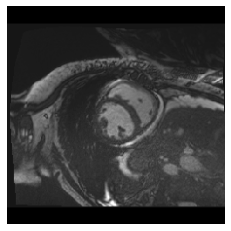

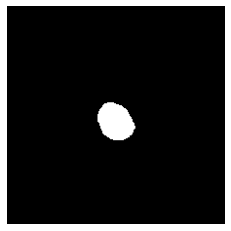

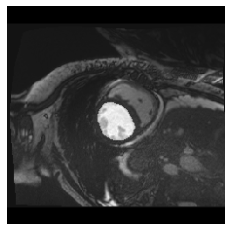

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
data = np.load('/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/train_npz/patient018_slice010.npz')
image, label = data['image'], data['label']
print(np.unique(label))
label = np.array(label == 3,dtype=np.uint8)
print(label.max())
image1 = (image * 255).astype(np.uint8)
label1 = (label*255).astype(np.uint8)
print(image.shape)
plt.imshow(image,'gray')
plt.axis('off')
plt.show()
plt.imshow(label,'gray')
plt.axis('off')
plt.show()
image_label = image+label*0.5
plt.imshow(image_label,'gray')
plt.axis('off')
plt.show()

[DATA INFO] Total Samples:1674
[DATA INFO] Single Organ is on. Only Single Organ Label 3 is Returning


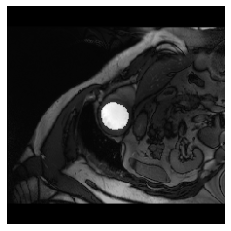

tensor([1], dtype=torch.uint8)


In [144]:
from cmath import sin
import os 
import cv2
import torch
import random
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt


class BaseDataSets_ACDC(Dataset):
    def __init__(self,root_dir='/home/jaye/Documents/MedicalDatasets/ACDC/processed_training/',
                    split='train',num=None,transform=None,single_model=True,organ_cls = 3):
        self.root_dir = root_dir
        self.sample_list = []
        self.split = split
        self.transform = transform
        self.single_model = single_model

        if single_model:
            self.organ_cls = organ_cls

        if self.split == "train":
            with open(self.root_dir + '/lists_ACDC/train.txt','r') as f:
                self.sample_list = f.readlines()
            self.sample_list = [item.replace('\n','') 
                                for item in self.sample_list]

        elif self.split == "val":
            with open(self.root_dir + '/lists_ACDC/test.txt','r') as f:
                self.sample_list = f.readlines()
            self.sample_list = [item.replace('\n','') 
                                for item in self.sample_list]

        if num is not None and self.split == 'train':
            self.sample_list = self.sample_list[:num]

        print(f"[DATA INFO] Total Samples:{len(self.sample_list)}")
        if single_model:
            print(f"[DATA INFO] Single Organ is on. Only Single Organ Label {organ_cls} is Returning")
        

    def __len__(self):
        return len(self.sample_list)
    
    def __getitem__(self, idx):
        case = self.sample_list[idx]
        if self.sample_list == "train":
            data_path = os.path.join(self.root_dir,"train_npz", case )
            data = np.load(data_path)
        else: 
            data_path = os.path.join(self.root_dir,"train_npz", case )
            data = np.load(data_path)

        image, label = data['image'], data['label']
        if self.single_model:
            seg_label = (label == self.organ_cls).astype(np.uint8)
            cls_label = seg_label.max()
            sample = {'image':image,'cls_label':cls_label,'seg_label':seg_label}
        else:
            sample = {'image':image,'seg_label':seg_label}
        if self.transform is not None:
            sample = self.transform(sample)
        sample["idx"] = idx
        return sample
    
class BaseDataset_CHAOS(Dataset):
    def __init__(self,root_dir='./CHAOS/train') -> None:
        super().__init__()

def build_loader(config,num,transform):

    if config.DATASET == "ACDC":
        train_ds = BaseDataSets_ACDC(split='train',num=num,transform=transform)
        val_ds   = BaseDataSets_ACDC(split='val',num=num,transform=transform)

        train_loader = torch.utils.data.Dataloader(train_ds,batch_size=config.DATA.BATCH_SZIE,shuffle=True,
                                                    num_workers=config.DATA.NUM_WORKERS,pin_memory=True,drop_last=False)
        val_loader   = torch.utils.data.Dataloader(val_ds,batch_size=config.DATA.BATCH_SZIE,shuffle=False,
                                                    num_workers=config.DATA.NUM_WORKERS,pin_memory=True,drop_last=False)
        return train_ds, val_ds, train_loader, val_loader
    if config.DATASET == "CHAOS":
        pass
    if config.DATASET == "ProMRI":
        pass

if __name__ == "__main__":
    train_ds = BaseDataSets_ACDC()
    train_loader = DataLoader(train_ds,batch_size=1,shuffle=True)
    for i,data in enumerate(train_loader):
        if i == 0:
            image, cls_label, seg_label = data['image'], data['cls_label'],data['seg_label']

            plt.imshow(image[0] + seg_label[0],'gray')
            plt.axis('off')
            plt.show()
            print(cls_label)
        else:
            break

        